# Start here for ease of training the model

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [7]:
# Reassigning columns to drop for ease of use & Reloading data for ease of use ()
df=pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df.columns = df.columns.str.strip()  # Remove leading and trailing spaces|

df_one_values = ['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

columns_to_drop = ['Active Mean',
 'Active Min',
 'Average Packet Size',
 'Avg Bwd Segment Size',
 'Avg Fwd Segment Size',
 'Bwd Header Length',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Bwd IAT Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Duration',
 'Flow IAT Max',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow Packets/s',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Fwd IAT Min',
 'Fwd IAT Std',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Idle Max',
 'Idle Mean',
 'Idle Min',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'Subflow Bwd Bytes',
 'Subflow Bwd Packets',
 'Subflow Fwd Bytes',
 'Subflow Fwd Packets',
 'Total Backward Packets',
 'Total Fwd Packets',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'act_data_pkt_fwd']

columns_to_drop_2 = ['Flow Bytes/s',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd Header Length',
 'Bwd Packets/s',
 'Init_Win_bytes_forward',
 'Active Std',
 'Active Max',
 'Idle Std']

# Tagging columns with the least information gain (Mostly due to close to zero variation in values)
columns_to_drop_3 = ['FIN Flag Count', 'RST Flag Count', 'ECE Flag Count']

### Creating Model

1. Create a pipeline that preprocess previous analysis
2. Run a standardization preprocessing + PCA (explaining 95% variance of data) for numerical columns
3. Run one hot encoding for Protocol column, and select K Best for the whole categorical columns with chi square as its scoring method
4. Run gridsearch with Random Forest and Logistic Regression

In [8]:
df1_analyze = df.drop(columns=['Source Port', 'Destination Port', 'Destination IP', 'Source IP', 'Flow ID', 'Fwd Header Length.1', 'Timestamp'])

# Drop any rows with nulls
df1_analyze = df1_analyze.drop(index=df1_analyze[df1_analyze.isnull().any(axis=1)].index)

# Drop any rows with infinity
df1_analyze = df1_analyze.drop(index=df1_analyze[df1_analyze.isin([np.inf, -np.inf]).any(axis=1)].index)

# Dropping columns with only 1 value
df1_analyze = df1_analyze.drop(columns=df_one_values)

# Dropping columns with high colinearity
df1_analyze = df1_analyze.drop(columns=columns_to_drop)

# Dropping columns that have low correlation with target
df1_analyze = df1_analyze.drop(columns=columns_to_drop_2)

# Dropping columns that have low mutual information gain with target
df1_analyze = df1_analyze.drop(columns=columns_to_drop_3)

# Change flags to boolean type
to_bool = []
for x in df1_analyze.columns:
    if "Flag" in x:
        to_bool.append(x)
df1_analyze[to_bool] = df1_analyze[to_bool].astype('bool')

# Changing Label to 0 and 1
df1_analyze['Label'] = df1_analyze['Label'].apply(lambda x: 1 if x == "DDoS" else 0)
df1_analyze['Label'] = df1_analyze['Label'].astype('bool')

df1_analyze.shape

(225711, 18)

In [9]:
df1_analyze.columns

Index(['Protocol', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Bwd Packet Length Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'Fwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'SYN Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_backward', 'min_seg_size_forward', 'Label'],
      dtype='object')

In [8]:
# Splitting data for training and testing
train_friday, test_friday = train_test_split(df1_analyze, test_size=0.3, random_state=42)

X_train_friday = train_friday.drop(columns='Label')
y_train_friday = train_friday['Label']
X_test_friday = test_friday.drop(columns='Label')
y_test_friday = test_friday['Label']

categorical_column = X_train_friday.select_dtypes('bool').columns
numerical_columns = X_train_friday.select_dtypes('number').columns

#### Random Forest

In [ ]:
# Creating model pipeline
ohe = OneHotEncoder(handle_unknown="ignore")
pca = PCA(n_components=0.98)
selectk = SelectKBest(chi2, k=1)

numerical_pipeline = Pipeline([('standard_scaler', StandardScaler()), ('pca', pca)])

categorical_column_transformer = ColumnTransformer(
    [('one_hot_encoder', ohe, ['Protocol']),
     ('nothing', 'passthrough', categorical_column)]
)
categorical_pipeline = Pipeline([('cat_transformer', categorical_column_transformer), ('select_k', selectk)])

preprocessor = ColumnTransformer(
    [('cat_processing', categorical_pipeline, ['Protocol'] + list(categorical_column)),
     ('num_processing', numerical_pipeline, numerical_columns),]
)

estimator = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_split=0.1)

param_random = {
    'preprocessing__cat_processing__select_k__k':range(6),
    'prediction__max_depth': range(1, 20),
    'prediction__min_samples_split': stats.uniform(0.1, 0.4),
    'prediction__n_estimators': [100, 300, 500, 1000]
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, n_iter=20, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [28]:
random_search.fit(X_train_friday, y_train_friday)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'prediction__max_depth': range(1, 20),
                                        'prediction__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B0F7CFF40>,
                                        'prediction__n_estimators': [100, 300,
                                                                     500,
                                                                     1000],
                                        'preprocessing__cat_processing__select_k__k': range(0, 6)},
                   random_state=42, scoring='accuracy', verbose=2)

In [29]:
random_search.best_params_

{'prediction__max_depth': 19,
 'prediction__min_samples_split': 0.13998996632720118,
 'prediction__n_estimators': 500,
 'preprocessing__cat_processing__select_k__k': 4}

In [30]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     29321
        True       0.99      0.99      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



Text(0.5, 1.0, 'Confusion Matrix')

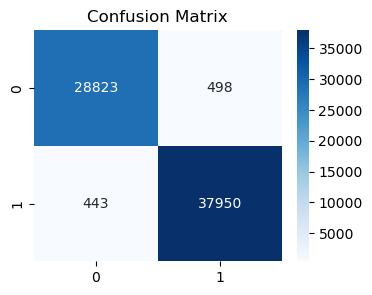

In [93]:
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')

In [94]:
with open('model_1_rf_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

#### Decision Tree

In [ ]:
# Creating model pipeline
estimator = DecisionTreeClassifier(random_state=42, min_samples_split=0.1)

param_random = {
    'preprocessing__cat_processing__select_k__k':range(3),
    'prediction__max_depth': range(1, 5),
    'prediction__min_samples_split': stats.uniform(0.1, 0.4)  
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [97]:
random_search.fit(X_train_friday,y_train_friday)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                                             ('prediction',
                                              DecisionTreeClassifier(min_samples_split=0.1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'prediction__max_depth': range(1, 5),
                                        'prediction__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000250A327E8B0>,
                                        'preprocessing__cat_processing__select_k__k': range(0, 3)},
                   random_state=42, scoring='accuracy', verbose=2)

In [98]:
random_search.best_params_

{'prediction__max_depth': 4,
 'prediction__min_samples_split': 0.1571467271687763,
 'preprocessing__cat_processing__select_k__k': 2}

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     29321
        True       0.99      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



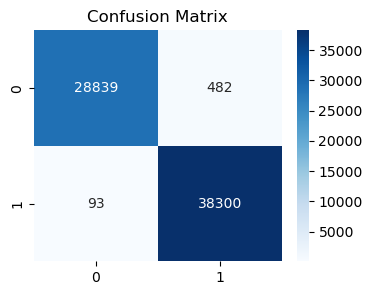

In [100]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [101]:
with open('model_1_dt_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

#### Logistic Regression

In [22]:
estimator = LogisticRegression(max_iter=3000, solver='saga', penalty='elasticnet', random_state=42)

param_random= {
    'preprocessing__cat_processing__select_k__k':range(5),
    'prediction__l1_ratio': stats.uniform(),
    'prediction__C': stats.loguniform(1e-3, 1e2)
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, n_iter=20, param_distributions=param_random, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

In [23]:
random_search.fit(X_train_friday,y_train_friday)

c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                                                                 solver='saga'))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'prediction__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B0F57F640>,
                                        'prediction__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B0F4FCDC0>,
                                        'preprocessing__cat_processing__select_k__k': range(0, 5)},
                   random_state=42, scoring='accuracy')

In [24]:
random_search.best_params_

{'prediction__C': 67.32248920775338,
 'prediction__l1_ratio': 0.8083973481164611,
 'preprocessing__cat_processing__select_k__k': 0}

c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


              precision    recall  f1-score   support

       False       1.00      0.97      0.98     29321
        True       0.98      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.98      0.99     67714
weighted avg       0.99      0.99      0.99     67714



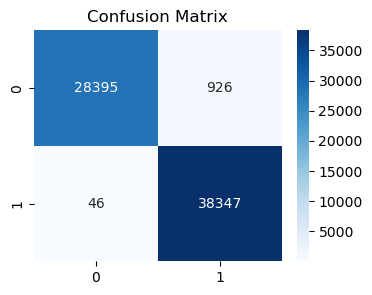

In [25]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [116]:
with open('model_1_logreg_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

#### XGBoost Tree Model

In [36]:
estimator = XGBClassifier(booster= 'gbtree', random_state=42)

param_random= {
    'preprocessing__cat_processing__select_k__k':range(5),
    'prediction__learning_rate': stats.loguniform(1e-4, 0.1),
    'prediction__max_depth': stats.randint(2, 20),
    'prediction__gamma': stats.loguniform(1e-8, 1)
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, n_iter=20, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [37]:
random_search.fit(X_train_friday,y_train_friday)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                   param_distributions={'prediction__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B389E5AF0>,
                                        'prediction__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B38A34A90>,
                                        'prediction__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014B3896FF40>,
                                        'preprocessing__cat_processing__select_k__k': range(0, 5)},
                   random_state=42, scoring='accuracy', verbose=2)

In [38]:
random_search.best_params_

{'prediction__gamma': 9.91564456663839e-06,
 'prediction__learning_rate': 0.07114476009343418,
 'prediction__max_depth': 12,
 'preprocessing__cat_processing__select_k__k': 4}

              precision    recall  f1-score   support

       False       1.00      0.99      0.99     29321
        True       0.99      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



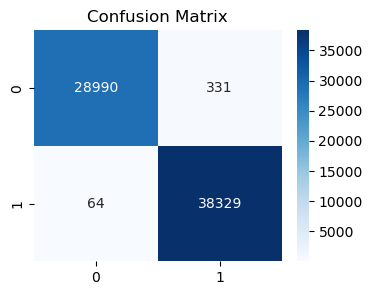

In [40]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [41]:
with open('model_1_xgb_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

### SVC Model

In [18]:
estimator = SVC(kernel='linear',gamma=10, C=100)

param_random= {
    'preprocessing__cat_processing__select_k__k':range(3),
    'prediction__kernel': ['linear', 'poly', 'rbf'],
    'prediction__gamma': stats.loguniform(0.1, 100),
    'prediction__C': stats.loguniform(1e-3, 1e2)
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [19]:
pipeline.fit(X_train_friday,y_train_friday)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat_processing',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                                                    ['Protocol']),
                                                                                                   ('nothing',
                                                                                                    'passthrough',
                                                                                                    Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count'],
      dtype='object'))])),
                                                                  (...
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.98))]),
                                                  Index(['Protocol', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Bwd Packet Length Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Fwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Down/Up Ratio', 'Init_Win_bytes_backward', 'min_seg_size_forward'],
      dtype='object'))])),
                ('prediction', SVC(C=100, gamma=10, kernel='linear'))])

In [ ]:
random_search.best_params_

{'prediction__C': 7.915074397656213,
 'prediction__l1_ratio': 0.6371651421518383,
 'preprocessing__cat_processing__select_k__k': 1}

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     29321
        True       0.98      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



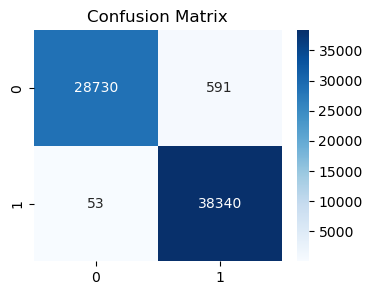

In [20]:
# prediction = random_search.best_estimator_.predict(X_test_friday)
prediction = pipeline.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with open('model_1_svc_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

#### XGBoost Linear

In [79]:
estimator = XGBClassifier(booster= 'gblinear', random_state=42)

param_random= {
    'preprocessing__cat_processing__select_k__k':range(10),
    'prediction__learning_rate': stats.loguniform(1e-4, 0.1),
    'prediction__reg_alpha': stats.loguniform(1e-8, 1),
    'prediction__reg_lambda': stats.loguniform(1e-8, 1)
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, n_iter=20, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [80]:
random_search.fit(X_train_friday,y_train_friday)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\an

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                   param_distributions={'prediction__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B72C67A00>,
                                        'prediction__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B72C54A60>,
                                        'prediction__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014B7BD40E20>,
                                        'preprocessing__cat_processing__select_k__k': range(0, 10)},
                   random_state=42, scoring='accuracy', verbose=2)

In [81]:
random_search.best_params_

{'prediction__learning_rate': 0.07866216981266842,
 'prediction__reg_alpha': 0.0007182472659393415,
 'prediction__reg_lambda': 1.6143342323367594e-06,
 'preprocessing__cat_processing__select_k__k': 0}

c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


              precision    recall  f1-score   support

       False       1.00      0.89      0.94     29321
        True       0.92      1.00      0.96     38393

    accuracy                           0.95     67714
   macro avg       0.96      0.94      0.95     67714
weighted avg       0.95      0.95      0.95     67714



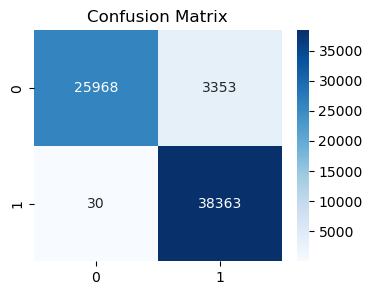

In [82]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [83]:
with open('model_1_xgblinear_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

# Combining Model 1 & 2

In [ ]:
with open('model_1_rf_randomsearch.pkl', 'rb') as file:
    model_1 = pickle.load(file)

with open('model_2_rf_randomsearch.pkl', 'rb') as file:
    model_2 = pickle.load(file)

def ddos_predictor(X: pd.DataFrame) -> pd.DataFrame:
    prediction_1 = model_1.predict(X)
    prediction_2 = model_2.predict(X)
    for i in range(len(prediction_1)):
        if not prediction_1[i]:
            prediction_2[i] = 0
    return prediction_2

array([False])

# Testing the model on another dataset (CIC 2019)

In [49]:
# Reading the file
cic_df=pd.read_csv('cicddos2019_dataset.csv', index_col=0)

# Renaming columns to match the model
rename_column =  {'Packet Length Max': 'Max Packet Length',
                  'Init Fwd Win Bytes':'Init_Win_bytes_forward',
                  'Bwd Packets Length Total':'Total Length of Bwd Packets',
                  'Packet Length Min':'Min Packet Length',
                  'Fwd Seg Size Min':'min_seg_size_forward',
                  'Fwd Act Data Packets':'act_data_pkt_fwd',
                  'Avg Packet Size':'Average Packet Size',
                  'Init Bwd Win Bytes':'Init_Win_bytes_backward',
                  'Fwd Packets Length Total':'Total Length of Fwd Packets'
                }
cic_df = cic_df.rename(columns=rename_column)
cic_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,35.088460,0.0,0.0,0.0,0.0,9.638510e+03,27.696867,43326.2,59304.016,108616.0,0.0,216631.0,43326.2,59304.016,108616.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,96,0,27.696867,0.0,321.0,393.0,344.14285,33.617596,1130.1428,0,0,0,0,0,0,0,0,0.0,401.5,348.0,0.0,0,0,0,0,0,0,6,2088,0,0,-1,-1,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
1,17,2,2,0,802.0,0.0,401.0,401.0,401.0,0.000000,0.0,0.0,0.0,0.0,4.010000e+08,1000000.000000,2.0,0.000,2.0,2.0,2.0,2.0,0.000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,1000000.000000,0.0,401.0,401.0,401.00000,0.000000,0.0000,0,0,0,0,0,0,0,0,0.0,601.5,401.0,0.0,0,0,0,0,0,0,2,802,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
2,17,48,2,0,766.0,0.0,383.0,383.0,383.0,0.000000,0.0,0.0,0.0,0.0,1.595833e+07,41666.668000,48.0,0.000,48.0,48.0,48.0,48.0,0.000,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,41666.668000,0.0,383.0,383.0,383.00000,0.000000,0.0000,0,0,0,0,0,0,0,0,0.0,574.5,383.0,0.0,0,0,0,0,0,0,2,766,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
3,17,107319,4,0,1398.0,0.0,369.0,330.0,349.5,22.516660,0.0,0.0,0.0,0.0,1.302658e+04,37.272057,35773.0,61959.790,107318.0,0.0,107319.0,35773.0,61959.790,107318.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,80,0,37.272057,0.0,330.0,369.0,345.60000,21.361180,456.3000,0,0,0,0,0,0,0,0,0.0,432.0,349.5,0.0,0,0,0,0,0,0,4,1398,0,0,-1,-1,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
4,17,107271,4,0,1438.0,0.0,389.0,330.0,359.5,34.063667,0.0,0.0,0.0,0.0,1.340530e+04,37.288734,35757.0,61931.207,107269.0,1.0,107271.0,35757.0,61931.207,107269.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,32,0,37.288734,0.0,330.0,389.0,353.60000,32.315630,1044.3000,0,0,0,0,0,0,0,0,0.0,442.0,359.5,0.0,0,0,0,0,0,0,4,1438,0,0,-1,-1,3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [50]:
# Drop any rows with nulls
cic_df = cic_df.drop(index=cic_df[cic_df.isnull().any(axis=1)].index)

# Drop any rows with infinity
cic_df = cic_df.drop(index=cic_df[cic_df.isin([np.inf, -np.inf]).any(axis=1)].index)

# Change flags to boolean type
to_bool = []
for x in cic_df.columns:
    if "Flag" in x:
        to_bool.append(x)
cic_df[to_bool] = cic_df[to_bool].astype('bool')

# Changing Label to 0 and 1
cic_df['Label'] = cic_df['Label'].apply(lambda x: 0 if x == "Benign" else 1)
cic_df['Label'] = cic_df['Label'].astype('bool')

# Separating features from target
X_cic = cic_df.drop(columns=['Label','Class'])
y_cic = cic_df['Label']

#### Random Forest Model

              precision    recall  f1-score   support

       False       0.23      0.99      0.37     97831
        True       0.93      0.03      0.05    333540

    accuracy                           0.25    431371
   macro avg       0.58      0.51      0.21    431371
weighted avg       0.77      0.25      0.13    431371



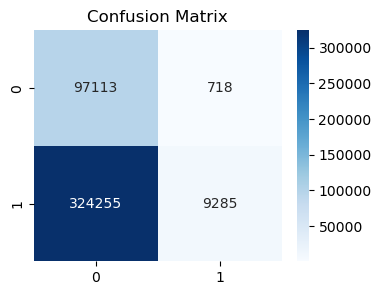

In [53]:
with open('model_1_rf_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

#### Decision Tree Model

              precision    recall  f1-score   support

       False       0.24      0.99      0.38     97831
        True       0.97      0.06      0.11    333540

    accuracy                           0.27    431371
   macro avg       0.60      0.53      0.25    431371
weighted avg       0.80      0.27      0.17    431371



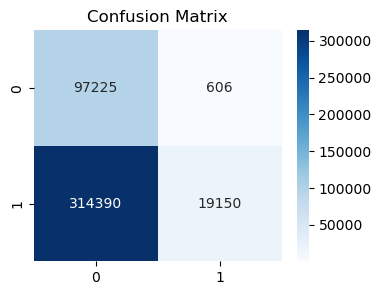

In [54]:
with open('model_1_dt_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

#### Logistic Regression Model

              precision    recall  f1-score   support

       False       0.41      0.97      0.58     97831
        True       0.98      0.60      0.74    333540

    accuracy                           0.68    431371
   macro avg       0.70      0.78      0.66    431371
weighted avg       0.85      0.68      0.71    431371



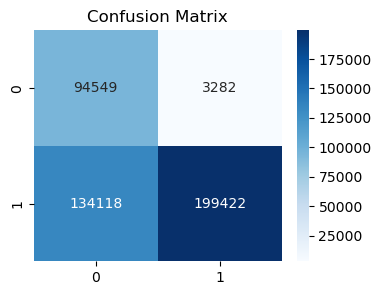

In [51]:
with open('model_1_logreg_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [34]:
loaded_model_pickle.best_params_

{'prediction__C': 7.915074397656213,
 'prediction__l1_ratio': 0.6371651421518383,
 'preprocessing__cat_processing__select_k__k': 1}

#### XGBoost Tree

              precision    recall  f1-score   support

       False       0.24      1.00      0.38     97831
        True       0.98      0.06      0.10    333540

    accuracy                           0.27    431371
   macro avg       0.61      0.53      0.24    431371
weighted avg       0.81      0.27      0.17    431371



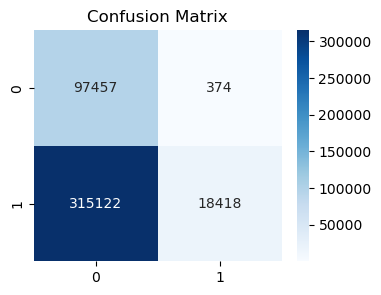

In [52]:
with open('model_1_xgb_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.22      0.81      0.34     97831
        True       0.72      0.15      0.25    333540

    accuracy                           0.30    431371
   macro avg       0.47      0.48      0.29    431371
weighted avg       0.61      0.30      0.27    431371



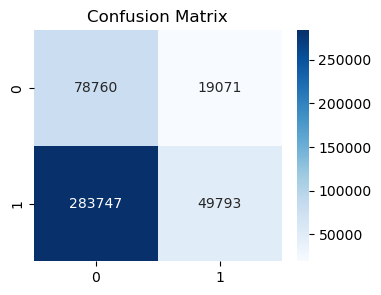

In [84]:
with open('model_1_xgblinear_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()